In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse.linalg as spLA
import numpy.linalg as LA

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

In [33]:
N_tot = 1000
N_men = N_tot // 2
N_women = N_tot // 2

# Generate ranks
s_men = np.random.uniform(low=1, high=10, size=N_men)
s_women = np.random.uniform(low=1, high=10, size=N_women)

In [36]:
alpha = 1
beta = 0.5

Z = 0
scaled_energy = np.zeros((N_men, N_men))
for i in range(N_men):
    for j in range(N_men):
        energy_ij = 0.5 * np.power(s_men[i] - s_men[j] - 1, 2)
        scaled_energy[i, j] =  np.exp(-beta * energy_ij)
        Z += scaled_energy[i, j]
c = 10 * N_men / Z

In [51]:
A = np.zeros((N_men, N_men))
for i in range(N_men):
    for j in range(N_men):
        if i == j:
            continue
        energy_ij = 0.5 * np.power(s_men[i] - s_men[j] - 1, 2)
        scaled_energy_ij =  np.exp(-beta * energy_ij)
        A[i, j] += np.random.poisson(c * scaled_energy_ij)

In [52]:
s_est = sr.SpringRank(A)

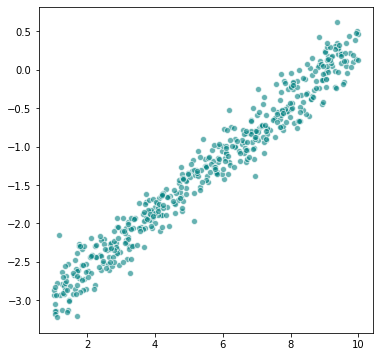

In [53]:
plt.figure(figsize=(6, 6))

plt.scatter(s_men, s_est, color='teal', edgecolor='white', alpha=0.6)

plt.show()